In [1]:
%load_ext autoreload
%autoreload 2

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import numpy as np
import json
from random import sample

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [3]:
import torch
import torch.nn.functional as F

from transformers import *

In [4]:
models = {}

In [5]:
model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-base', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loading state_dict took 0.409 sec


In [6]:
model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-large', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

loading state_dict took 1.285 sec


Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-large and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
model_class, tokenizer_class, shortcut, mask_token = GPT2LMHeadModel, GPT2Tokenizer, 'gpt2', None
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

In [21]:
model_class, tokenizer_class, shortcut, mask_token = GPT2LMHeadModel, GPT2Tokenizer, 'gpt2-large', None
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

In [48]:
model_class, tokenizer_class, shortcut, mask_token = GPT2LMHeadModel, GPT2Tokenizer, 'gpt2-xl', None
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

In [7]:
model, tokenizer, mask_token = models['roberta-large']

In [8]:
import re
import pandas as pd
import collections
import os
import nltk
import random

In [9]:
# 处理上下位->hyponyms_dict
# am-for-bert
am_for_bert = 'am_for_bert.txt'

with open(am_for_bert, 'r') as f:
    file_lines = f.readlines()

keymap =  [re.split(' |\t',string) for string in file_lines]
am_for_bert_hyponyms_dict = {}
for item in keymap:
    # 筛选出形态词的上位词
    if ('hypernym' == item[4]):
        master = item[2]
        slave = []
        length = len(item)
        
        for i in range(int((length-5)/2)):
            slave.append(item[5+i*2])
            
        # 最终的数据 am_for_bert_hyponyms_dict        
        am_for_bert_hyponyms_dict[master] = slave       


# DiffVec
filename = 'diffvec_word_pairs_final.SEMBLESS.csv'
file_colname=['relation','word1','word2']
df = pd.read_csv(filename,header=None,names=file_colname)
df = df[df['relation'].str.contains('hyper')]
# 最后的数据是DiffVec_hyponyms_dict
DiffVec_hyponyms_dict = df.groupby(['word2'])['word1'].apply(list).to_dict()


# 合并数据
hyponyms_dict = {}
hyponyms_dict.update(am_for_bert_hyponyms_dict)
hyponyms_dict.update(DiffVec_hyponyms_dict)
#print(hyponyms_dict)
print(len(hyponyms_dict))


7916


In [339]:
# 把dict的词替换到句子模板
template = [ 'What is a * _ ? It is a kind of * = .',
           '* _ is a kind of * = .',
           'It is reasonable to regard * _ as a kind of * = .',
           'What is a * _ ? * It is a kind of = .']
# 一个句子对应一张图
texts = []
one = template[3]
for (key,value) in hyponyms_dict.items():
            for word in value:
                example = one.replace('_', key).replace('=', word)
                texts.append(example)
#print(texts[8:20])
print(len(texts))     

32592


In [340]:
# 得到attention值
# 随机抽样5000条
texts = random.sample(texts, 3000)

all_attn_probs, idx_pairs, tokenses = [], [], []
for text in tqdm(texts):
    if mask_token is not None:
        text = text.replace(' _ ', ' %s ' % mask_token)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(text, add_special_tokens=True))
    tokens = ['*' if token in ['*', 'Ġ*'] else token for token in tokens]
    marker = '*'
    if marker in tokens:
        assert tokens.count(marker) == 2, str(tokens)
        p, h = [i for i, token in enumerate(tokens) if token == marker]
        tokens = [token for token in tokens if token != marker]
        h -= 1
        #print(tokens[p], tokens[h])
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    pred_idx = [i for i, token in enumerate(tokens) if token == mask_token] if mask_token is not None else [-1]
    tokens = ['@' + token if not token.startswith('Ġ') and token not in ['<s>', '</s>', '<mask>'] else token.replace('Ġ', '') 
              for token in tokens] 
    #print(tokens)
    
    input_ids = torch.tensor([token_ids])
    with torch.no_grad():
        logits, attns = model(input_ids, output_attentions=True)
        probs = F.softmax(logits, dim=-1)

    attn_scores, attn_probs = zip(*attns)
    attn_scores, attn_probs = torch.cat(attn_scores, dim=0), torch.cat(attn_probs, dim=0)
    all_attn_probs.append(attn_probs)
    idx_pairs.append((p, h))
    tokenses.append(tokens)
    #print("===============================")
   # print(tokenses)
    #print(idx_pairs)
    #print(attn_probs[0, 0, 1, 1])
   # print(attn_probs[:, :, h, p])

# 求注意力值的平均值
attn_sum = np.zeros((24, 16),dtype='float32')
i = 0
for attn_one, (p, h) in zip(all_attn_probs, idx_pairs):    
    attn_every = np.array(attn_one[:, :, h, p])
   #求和
    attn_sum += attn_every
   # 记录总共有多少句子来求平均
    i = i+1
#sum = attn_sum.tolist()
#求平均
attn_average = attn_sum/i
average = attn_average.tolist()
#print(average)

100%|██████████| 3000/3000 [06:43<00:00,  7.43it/s]


Text(0.5, 33.0, 'Average-hyponyms-head')

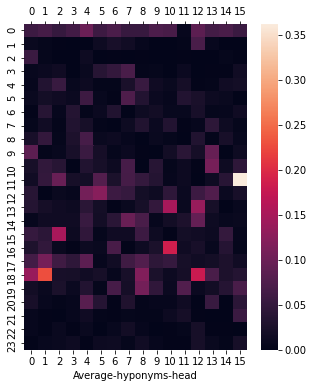

In [341]:
# 算平均后的head图
fig = plt.subplots(1,1,sharey=False, figsize=(5 , 6))
ax = sns.heatmap(attn_average)
ax.tick_params(top=True, labeltop=True)
ax.set_xlabel('Average-hyponyms-head')

<AxesSubplot:>

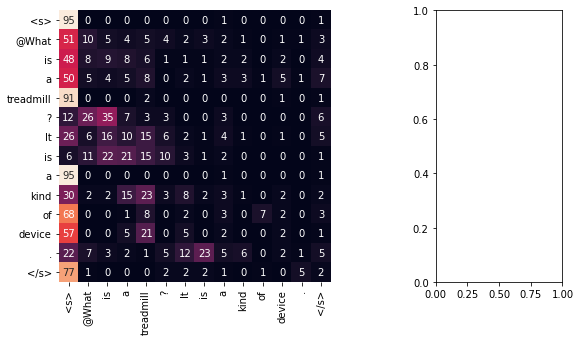

In [338]:
# 对于某个句子，某个head头内部分析
i = 638
layer, head = 12, 4
attn = all_attn_probs[i][layer, head]
tokens = tokenses[i]
size = round(attn.size(0) / 3)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(size  * 2., size), gridspec_kw={'width_ratios': [3, 1]})
sns.heatmap((attn * 100).long(), square=True, cbar=False, annot=True, fmt='d', xticklabels=tokens, yticklabels=tokens, ax=ax0)